In [1]:
import arviz as az
import bayeux as bx
import jax
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

# Using bayeux with TFP-on-JAX

`bayeux` has a built-in function for working with TFP models, `bx.Model.from_tfp`. [More on TensorFlow Probability here](https://www.tensorflow.org/probability/).

We implement a common hierarchical model of the eight schools dataset (Rubin 1981¹), whose details can be seen on the [Stan documentation](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html), [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools), [numpyro documentation](https://num.pyro.ai/en/stable/getting_started.html#a-simple-example-8-schools), among others.


¹ _Rubin, Donald B. 1981. “Estimation in Parallel Randomized Experiments.” Journal of Educational and Behavioral Statistics 6 (4): 377–401._

In [2]:
num_schools = 8
treatment_effects = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)
treatment_stddevs = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)

@tfd.JointDistributionCoroutineAutoBatched
def tfp_model():
  avg_effect = yield tfd.Normal(0., 10., name='avg_effect')
  avg_stddev = yield tfd.HalfNormal(10., name='avg_stddev')
  school_effects = yield tfd.Sample(
      tfd.Normal(0., 1.), sample_shape=8, name='school_effects')

  yield tfd.Normal(loc=avg_effect + avg_stddev * school_effects,
                   scale=treatment_stddevs, name='observed')

bx_model = bx.Model.from_tfp(
    tfp_model.experimental_pin(observed=treatment_effects))

In [3]:
idata = bx_model.mcmc.blackjax_nuts(seed=jax.random.key(0))

az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_effect,6.593,4.070,-1.180,14.317,0.054,0.043,5630.0,3278.0,1.0
avg_stddev,4.617,3.548,0.003,10.873,0.069,0.054,3387.0,2334.0,1.0
school_effects[0],0.341,0.973,-1.408,2.201,0.012,0.017,6129.0,2774.0,1.0
school_effects[1],0.055,0.912,-1.654,1.741,0.011,0.016,7001.0,2885.0,1.0
school_effects[2],-0.140,0.952,-1.973,1.590,0.012,0.015,6433.0,3189.0,1.0
school_effects[3],-0.000,0.933,-1.766,1.723,0.011,0.016,6824.0,3069.0,1.0
school_effects[4],-0.256,0.917,-1.879,1.543,0.013,0.014,4907.0,3054.0,1.0
school_effects[5],-0.139,0.942,-1.935,1.646,0.012,0.016,6657.0,3072.0,1.0
school_effects[6],0.338,0.944,-1.617,1.973,0.013,0.015,5215.0,2890.0,1.0
school_effects[7],0.056,0.954,-1.692,1.870,0.011,0.016,7033.0,3048.0,1.0


StructTuple(
  avg_effect=Array([6.170572 , 6.170516 , 6.1705165, 6.1705136, 6.170514 , 6.170519 ,
           6.1705165, 6.170516 ], dtype=float32),
  avg_stddev=Array([10.624942, 10.625168, 10.625167, 10.625159, 10.625164, 10.625158,
           10.625162, 10.625166], dtype=float32),
  school_effects=Array([[ 0.6820582 ,  0.09130666, -0.2641336 ,  0.03768046, -0.3825404 ,
            -0.2348828 ,  0.5903886 ,  0.14177026],
           [ 0.68643355,  0.09130628, -0.2641361 ,  0.03768098, -0.39293563,
            -0.23488228,  0.59038836,  0.14177173],
           [ 0.68643355,  0.09130625, -0.2641361 ,  0.0376812 , -0.39293563,
            -0.23488231,  0.5903883 ,  0.1417717 ],
           [ 0.6864335 ,  0.09130641, -0.26382452,  0.03768129, -0.39293548,
            -0.23488213,  0.59038854,  0.14177175],
           [ 0.68643355,  0.0913064 , -0.26413602,  0.03768126, -0.39293554,
            -0.23488219,  0.59038854,  0.14177175],
           [ 0.6864333 ,  0.09130613, -0.26413608,  0.037

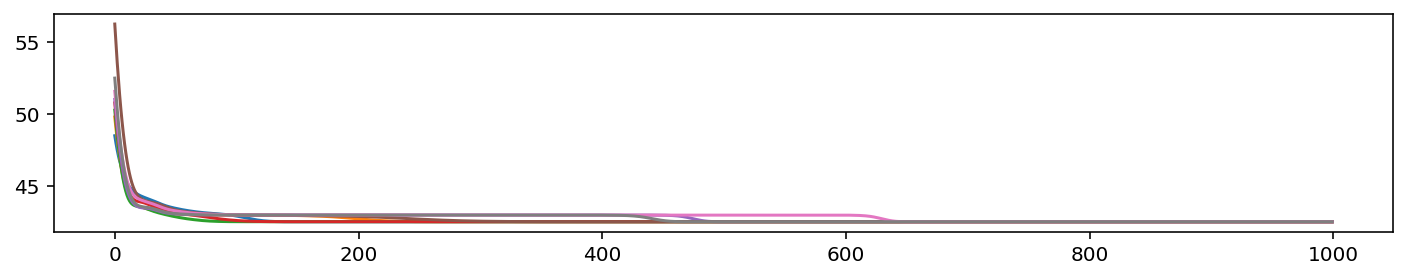

In [4]:
opt_results = bx_model.optimize.optax_adam(seed=jax.random.key(0))

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(opt_results.loss.T)
opt_results.params

StructTuple(
  avg_effect=Array(6.5087867, dtype=float32),
  avg_stddev=Array(3.7763548, dtype=float32),
  school_effects=Array([ 0.3577297 ,  0.06299979, -0.08964223, -0.02790713, -0.26249716,
           -0.1486009 ,  0.36491287,  0.05022464], dtype=float32)
)

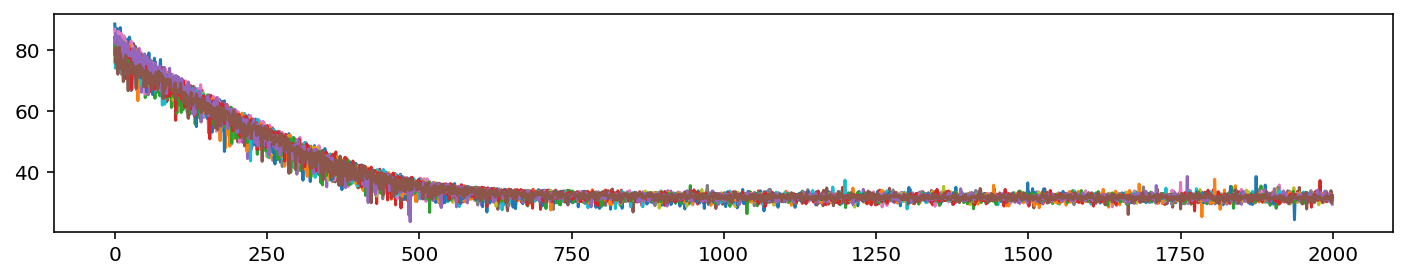

In [5]:
fit_key, draw_key = jax.random.split(jax.random.key(0))
surrogate_posterior, losses = bx_model.vi.tfp_factored_surrogate_posterior(
    seed=fit_key)


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(losses.T)

draws = surrogate_posterior.sample(100, seed=draw_key)
jax.tree_map(lambda x: np.mean(x, axis=(0, 1)), draws)